In [1]:
import pickle
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

In [48]:
XPost = []
PhiPost = []
NdkvPost = []
ZPost = []
APost = []

for i in np.linspace(100, 10000, 100).astype(int):
    PIK = "../../MCMC/UM03/sample_%d.dat" % i
    if i == 100:
        with open(PIK, "rb") as f:
            X = pickle.load(f)
            Z = pickle.load(f)
            Phi = pickle.load(f)
            Ndkv = pickle.load(f)
            A = pickle.load(f)
            Count = pickle.load(f)
    else:
        with open(PIK, "rb") as f:
            X = pickle.load(f)
            Z = pickle.load(f)
            Phi = pickle.load(f)
            Ndkv = pickle.load(f)
            A = pickle.load(f)
            Count = pickle.load(f)
    ZPost.extend(Z)
    APost.extend(A)
    PhiPost.extend(Phi)
    XPost.extend(X)
    NdkvPost.extend(Ndkv)

In [49]:
PIK = "../../data/Syndata7N.dat"

with open(PIK, "rb") as f:
    trueW = pickle.load(f)
    trueA = pickle.load(f)
    trueX = pickle.load(f)
    trueZ = pickle.load(f)
    trueRho = pickle.load(f)
    truePhi = pickle.load(f)
    trueGam = pickle.load(f)
    Nt = pickle.load(f)
    eta1 = pickle.load(f)
    eta2 = pickle.load(f)
    alpha = pickle.load(f)
    beta = pickle.load(f)

In [50]:
_, K, T = ZPost[-1].shape
_, D, __ = trueW.shape
colors = sns.color_palette('husl', K)

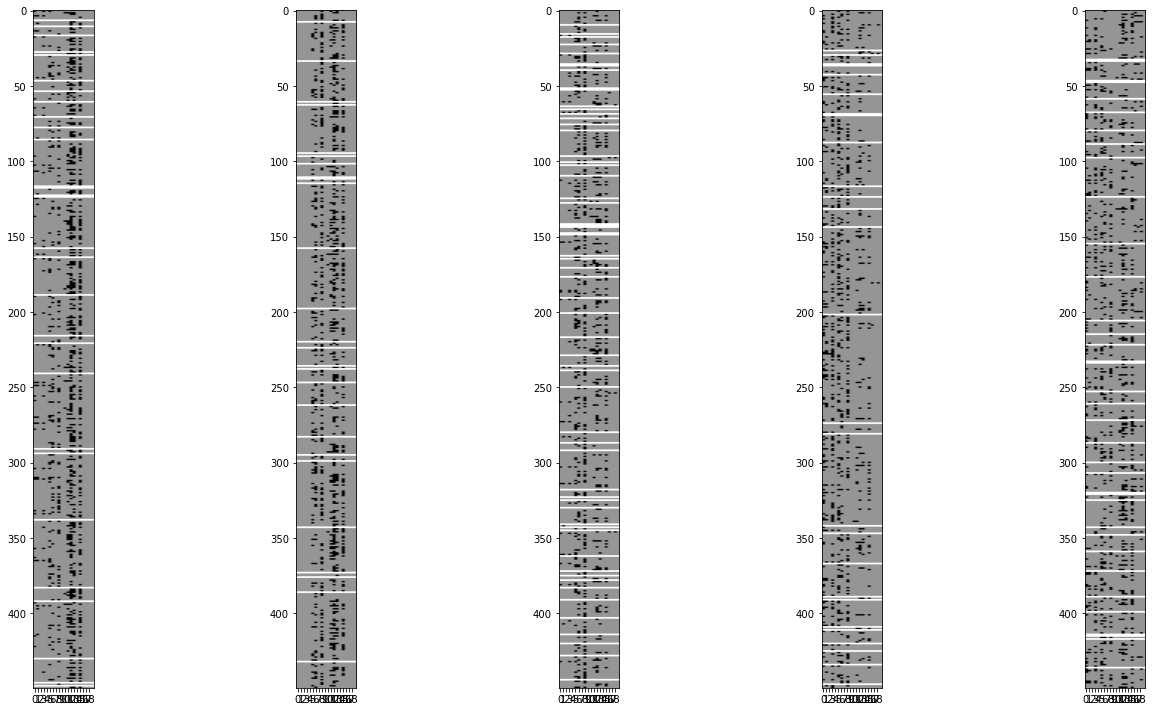

In [51]:
fig, axs = plt.subplots(nrows=1, ncols = 5, figsize=(20, 10))

for ax, t in zip(axs.ravel(), [0, 1, 2, 3, 4]):
    ax.imshow(trueW[:Nt[t],:,t], aspect=0.5, cmap='Greys')
    ax.set_xticks(np.arange(19))
plt.tight_layout()

In [52]:
def get_num_of_cls_per_obs( Z, Nt ):
    _, K, T = Z.shape
    stat = np.zeros((K+1, T))
    
    for t in range(T):
        idx, count = np.unique(Z[:Nt[t], :, t].sum(axis=1), return_counts=True)
        stat[idx, t] = count
    
    return stat

In [53]:
num_of_cls_per_obs = get_num_of_cls_per_obs(ZPost[-1], Nt)

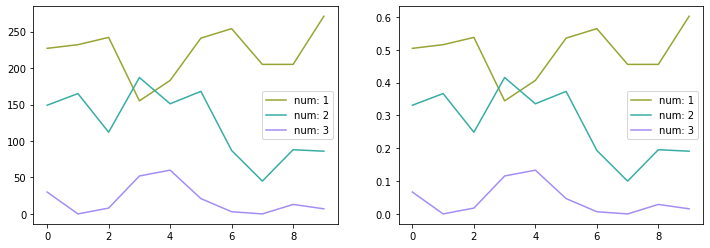

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for k in range(K):
    if k > 0:
        axs[0].plot(num_of_cls_per_obs[k], color=colors[k], label='num: %d' % k)
        axs[0].legend()
        axs[1].plot(num_of_cls_per_obs[k] / num_of_cls_per_obs.sum(axis=0), label='num: %d' % k, color=colors[k])
        axs[1].legend()

In [55]:
def get_num_of_cls_per_it( ZPost, Nt ):
    IT = len(ZPost)
    Z = ZPost[0]
    _, K, T = Z.shape
    stat = np.zeros((IT, K+1, T))
    
    for i in range(IT):
        for t in range(T):
            idx, count = np.unique(ZPost[i][:Nt[t], :, t].sum(axis=1), return_counts=True)
            stat[i, idx, t] = count
    
    return stat

In [56]:
cls_per_it = get_num_of_cls_per_it( ZPost, Nt )

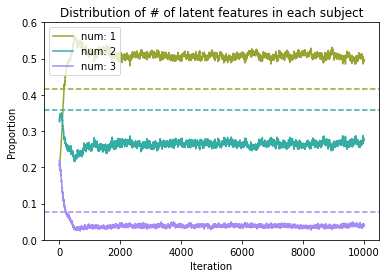

In [57]:
for k in range(1, K):
    plt.plot(cls_per_it[:, k, :].sum(axis=1) / sum(Nt), color=colors[k], label="num: %d" % k)
    plt.axhline(get_num_of_cls_per_it([trueZ], Nt)[:, k, :].sum(axis=1) / sum(Nt), color = colors[k], linestyle = "--")
plt.legend()
plt.ylim([0, 0.6])
plt.title("Distribution of # of latent features in each subject")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.show()

In [58]:
colors = sns.color_palette('hls', K)

In [59]:
burnin = 5000

x = np.transpose(np.mean(XPost[burnin:], axis=0))

# 90% Posterior interval: 5, 95 percentile value among posterior simulations
down = np.percentile(XPost[burnin:], axis=0, q=2.5, interpolation='nearest')
up = np.percentile(XPost[burnin:], axis=0, q=97.5, interpolation='nearest')

/var/folders/kv/8zn4jf1s0jxch5rjz712r5t00000gn/T/ipykernel_71879/3586909742.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  down = np.percentile(XPost[burnin:], axis=0, q=2.5, interpolation='nearest')
/var/folders/kv/8zn4jf1s0jxch5rjz712r5t00000gn/T/ipykernel_71879/3586909742.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  up = np.percentile(XPost[burnin:], axis=0, q=97.5, interpolation='nearest')


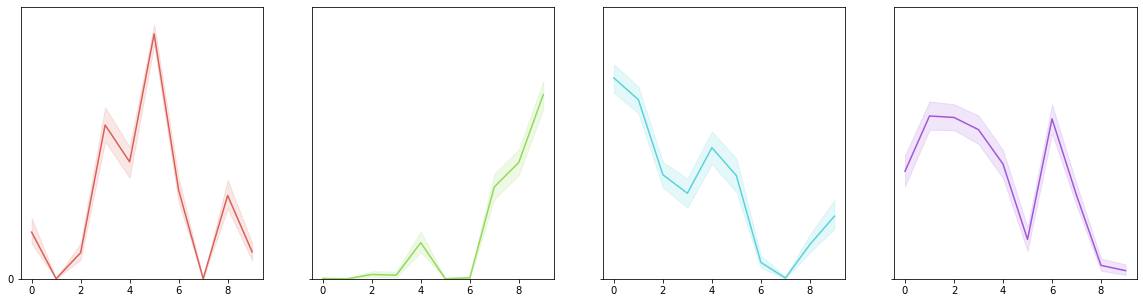

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=K, figsize=(20, 5), sharey='all')

for i, ax in enumerate(axs.ravel()):
    ax.plot(x[:, i], color=colors[i])
    ax.fill_between(np.arange(T), down[i, :], up[i, :], alpha=.15, color=colors[i])
    ax.set_yticks(np.arange(1))
    ax.set_ylim([0, 1])

In [61]:
def trace_rho( theArray, eta, eta2 ):
    """
        Returns Posterior mean of rho
    """
    L = len(theArray)
    D, K, V = theArray[0].shape
    
    
    postrho = np.zeros((D,K,L))
    for l in range(L):
        for k in range(K):
            postrho[:,k,l] = \
            ( theArray[l][:,k,1] + np.repeat(eta, D) ) / (np.repeat(eta+eta2, D) + np.sum(theArray[l][:,k,:], axis=1))
    

    return postrho

In [62]:
dist_rho = trace_rho(NdkvPost[burnin:], eta1, eta2)

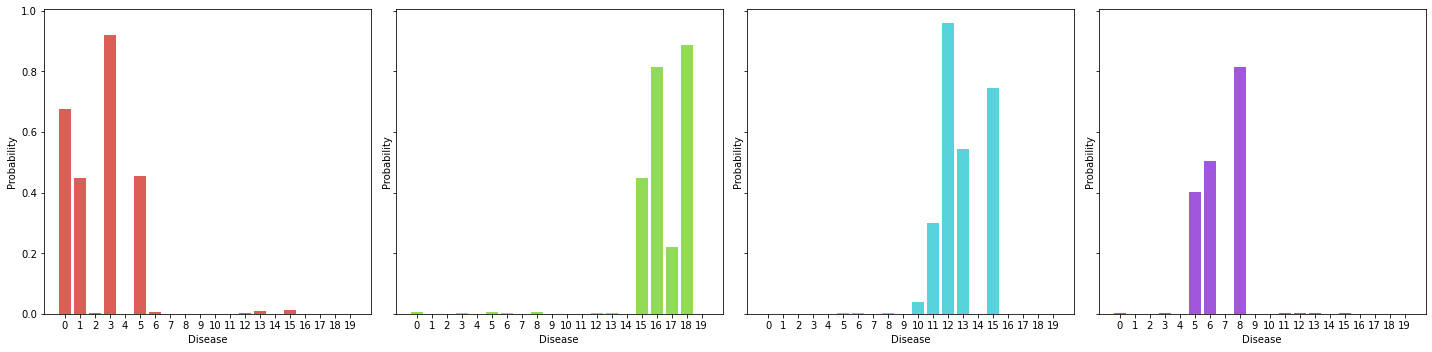

In [63]:
# To emphasize the closeness between inferred and true, we use more intense color than the color from trajectories

postRho = dist_rho.mean(axis=2)

fig, axs = plt.subplots(nrows=1, ncols=K, figsize=(20,5), sharex='all', sharey='all')

for k, ax in enumerate(axs.ravel()):
    ax.bar(np.arange(D), postRho[:, k], label='Inferred probability', color=colors[k])
    ax.set_xlabel("Disease")
    ax.set_ylabel("Probability")
    ax.set_xticks(np.arange(D))

plt.tight_layout()

plt.show()

In [64]:
from scipy.stats import bernoulli


def get_hood(inputA, inputB, sam):
    assert inputA.shape == inputB.shape, "two set should have the same shape"
    """
        Returns a list of indices whose i th entry is the inferred label corresponding to ith true label
        e.x. [2,1,0] means that the 2nd inferred cluster corresponds to 0th true cluster
    """
    # Generate a matrix whose (i,j) entry corresponds to 
    # the likelihood of jth inferred cluster conditioned on simulated obv from ith true cluster
    
    K = inputA.shape[0]
    loglihood = np.zeros((K,K))
    rvs = np.zeros((sam, inputA.shape[1]))

    for j in range(K):
        for i in range(sam):
            rvs[i,:] = list(map(lambda x: bernoulli.rvs(x), inputA[j,:]))
            for k in range(K):
                loglihood[j,k] += np.sum(list(map(lambda x,y : bernoulli.logpmf(x,y), rvs[i,:], inputB[k,:])))
    
    # Sort that matrix into discending order, and get their indices
    a, b = np.unravel_index(np.argsort(loglihood, axis=None), loglihood.shape)
    temp = [[i,j] for i,j in zip(a[::-1],b[::-1])]

    tempa = []
    tempb = []
    pair = []
    
    # Iterate the list of indices while saving the pair of the lowest distance on the fly
    # it preserves 1-1 mapping between clusters
    
    for item in temp:
        if item[0] not in tempa and item[1] not in tempb:
            pair.append(item)
            tempa.append(item[0])
            tempb.append(item[1])
            
    # output: list of pair and the sum of likelihood of these pairs
    
    return [item[1] for item in sorted(pair, key=lambda x: x[0])]

In [65]:
labelS = get_hood(trueRho, postRho.T, 50)
if labelS != np.arange(K).tolist():
    print("We need to switch the label")

We need to switch the label


Text(0.5, 1.0, 'Bold: Posterior mean, Dashed: True')

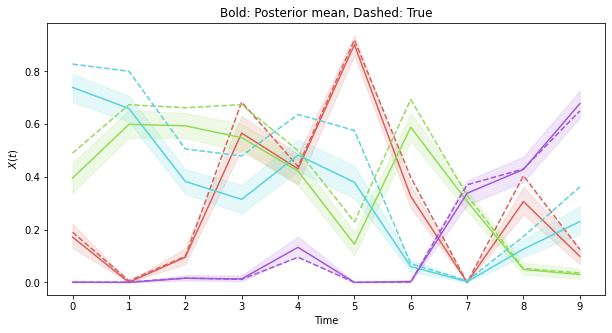

In [66]:
plt.figure(figsize=(10, 5))
for k in range(K):
    s = labelS[k]
    plt.plot(x[:, s], color=colors[k])
    plt.fill_between(np.arange(T), down[s, :], up[s, :], alpha=.15, color=colors[k])
    plt.plot(trueX[k], color=colors[k], linestyle='dashed')
    plt.xticks(np.arange(T))
plt.xlabel("Time")
plt.ylabel(r"$X(t)$")
plt.title("Bold: Posterior mean, Dashed: True")

Text(0.5, 0.98, 'Colored: Posterior mean, Black: True')

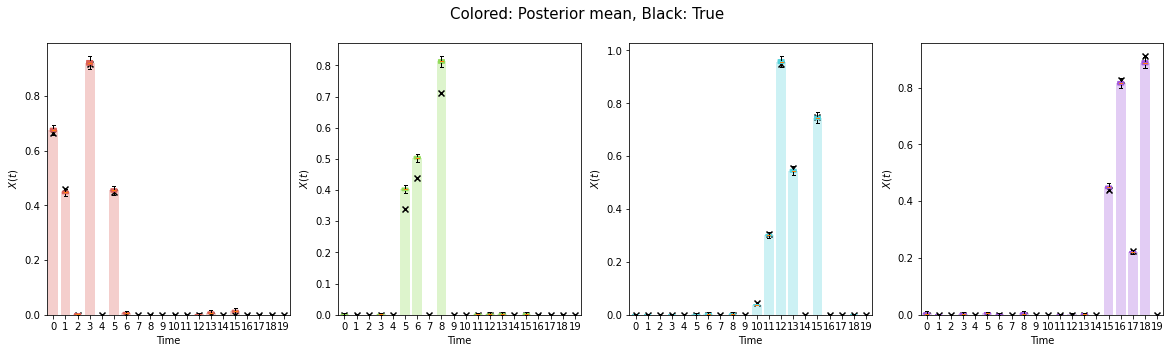

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=K, figsize=(20, 5))
for k, ax in enumerate(axs.ravel()):
    ax.bar(np.arange(D), postRho[:, labelS[k]], color=colors[k], alpha=0.3)
    
    # Creating boxplots with patch_artist=True
    boxplots = ax.boxplot(dist_rho[:, labelS[k], :].T, positions=np.arange(D), whis=[2.5, 97.5], notch=True, widths=0.5, showfliers=False, patch_artist=True)
    
    # Setting color for each box
    for patch in boxplots['boxes']:
#         patch.set_facecolor(colors[k])
#         patch.set_edgecolor(colors[k])
        patch.set_color(colors[k])
    
    ax.scatter(np.arange(D), trueRho[k, :], color='black', marker = "x")
    ax.set_xlabel("Time")
    ax.set_ylabel(r"$X(t)$")
plt.suptitle("Colored: Posterior mean, Black: True", fontsize=15)

In [68]:
def get_diseaseSet(W, Nt):
    maxNt, D, T = W.shape
    
    Dset = dict()
    for t in range(T):
        for i in range(Nt[t]):
            Dset.setdefault(tuple(np.arange(D)[W[i,:,t] > 0]),0)
            Dset[tuple(np.arange(D)[W[i,:,t] > 0])] += 1
    
    return Dset

def sum_values_for_each_ref(DSET, reference):
    sums = []
    
    for ref_sublist in reference:
        # Convert sublist to set for efficient membership checking
        ref_set = set(ref_sublist)
        
        # Calculate sum for this particular reference sublist
        ref_sum = sum(value for key, value in DSET.items() if any(k in ref_set for k in key))
        
        # Append the sum to the result list
        sums.append(ref_sum)

    return sums

In [69]:
pairs_count = get_diseaseSet(trueW, Nt)

In [70]:
sum_values_for_each_ref(pairs_count, [[7, 8, 10], [12, 13, 14, 15, 17], [1, 2, 4, 5]])

[1024, 1537, 1117]

In [71]:
def proportion_correctly_identified(ZPost, Z, labelS, Nt):
    T = Z.shape[2]
    res = 0
    for t in range(T):
        res += np.sum(np.all(ZPost[:Nt[t], labelS, t] == Z[:Nt[t], :, t], axis = 1))
    # Compute the proportion of correct identifications
    proportion = res / sum(Nt)
    return proportion

def feature_identified(ZPost, Z, labelS, Nt):
    T = Z.shape[2]
    res = 0
    total = 0
    for t in range(T):
        idx = Z[:, :, t].sum(axis=1) > 1
        temp = ZPost[idx, :, t]
        
        res += np.sum(np.all(temp[:, labelS] == Z[idx, :, t], axis = 1))
        total += np.sum(idx)
    # Compute the proportion of correct identifications
    proportion = res / total
    return proportion

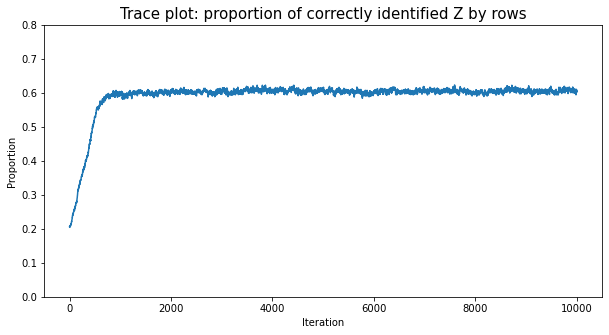

In [72]:
plt.figure(figsize=(10, 5))
plt.title("Trace plot: proportion of correctly identified Z by rows", fontsize=15)
plt.plot([proportion_correctly_identified(ZPost[i], trueZ, labelS, Nt) for i in range(len(ZPost))])
plt.ylim([0.0, 0.80])
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.show()

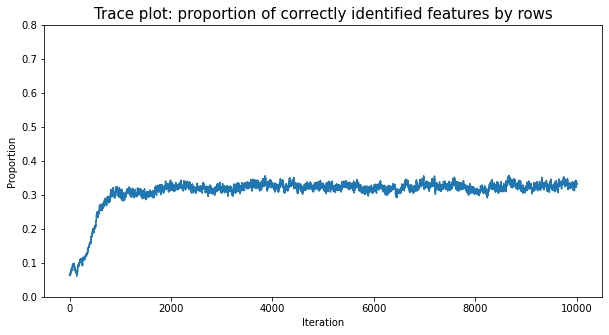

In [73]:
plt.figure(figsize=(10, 5))
plt.title("Trace plot: proportion of correctly identified features by rows", fontsize=15)
plt.plot([feature_identified(ZPost[i], trueZ, labelS, Nt) for i in range(len(ZPost))])
plt.ylim([0.0, 0.80])
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.show()

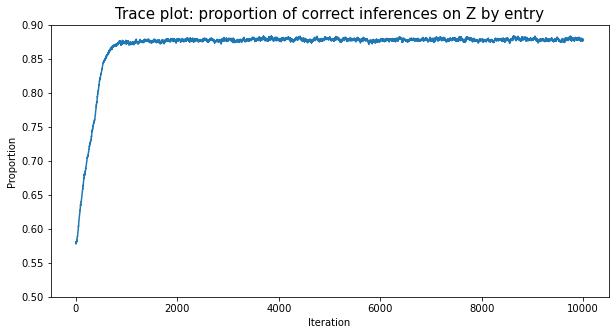

In [74]:
plt.figure(figsize=(10, 5))
plt.title("Trace plot: proportion of correct inferences on Z by entry", fontsize=15)
plt.plot([np.sum([ZPost[i][:, labelS, :] == trueZ])/trueZ.size for i in range(len(ZPost))])
plt.ylim([0.5, 0.90])
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.show()

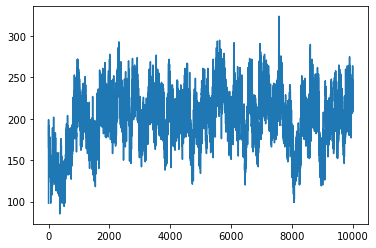

In [75]:
plt.plot([np.sum(ZPost[i-1] != ZPost[i]) for i in range(1, len(ZPost))])

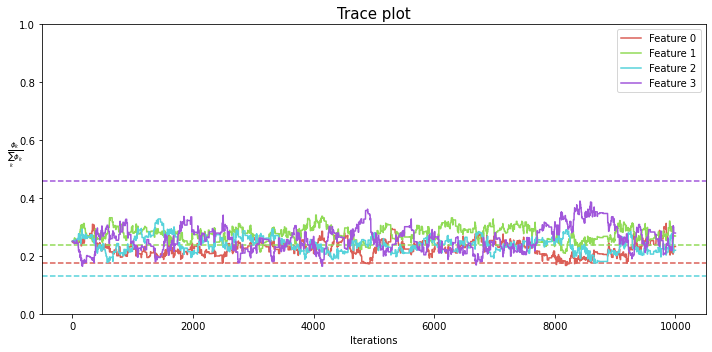

In [76]:
phiProp = np.array([item/sum(item) for item in PhiPost])

plt.figure(figsize=(10, 5))
for k in range(K):
    plt.plot(phiProp[:, labelS[k]], color=colors[k], label='Feature %d' % k)
    plt.axhline(truePhi[k]/truePhi.sum(), color=colors[k], linestyle = "--")
    plt.xlabel("Iterations")
    plt.ylabel(r"$\frac{\phi_{k}}{\sum_{k}\phi_{k}}$", rotation = 0)
    plt.title("Trace plot", rotation=0, fontsize=15)
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()    

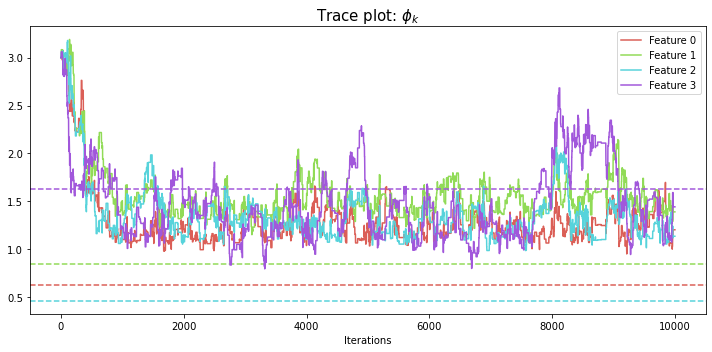

In [77]:
plt.figure(figsize=(10, 5))
for k in range(K):
    plt.plot([item[labelS[k]] for item in PhiPost], color=colors[k], label='Feature %d' % k)
    plt.axhline(truePhi[k], color=colors[k], linestyle = "--")
    plt.xlabel("Iterations")
    plt.title("Trace plot: " + r"$\phi_{k}}$", rotation=0, fontsize=15)
plt.legend()
plt.tight_layout()  

**Posterior trace plot: negative log-likelihood**

In [78]:
def compute_lik( W, A, Ndkv ):
    """
        Returns avg. negative log-likelihood
        
    """
    rho = get_rho([Ndkv], eta1, eta2)
    
    Didx = np.where(W >= 0)[1]
    Aitd = A[W >= 0]
    Witd = W[W >= 0]
    
    return bernoulli.logpmf(Witd, rho[Didx, Aitd]).sum()

def get_rho( theArray, eta, eta2 ):
    """
        Returns Posterior mean of rho
    """
    L = len(theArray)
    D, K, V = theArray[0].shape
    
    
    postrho = np.zeros((D,L,K))
    for l in range(L):
        for k in range(K):
            postrho[:,l,k] = \
            ( theArray[l][:,k,1] + np.repeat(eta, D) ) / (np.repeat(eta+eta2, D) + np.sum(theArray[l][:,k,:], axis=1))
    
    Rho = np.mean(postrho, axis=1)
    

    return Rho

In [79]:
import tqdm as tq

loglik = []
for i in tq.tqdm(range(len(APost))):
    loglik.append(compute_lik(trueW, APost[i], NdkvPost[i]))

100%|██████████████████████████████████████| 10000/10000 [01:00<00:00, 166.24it/s]


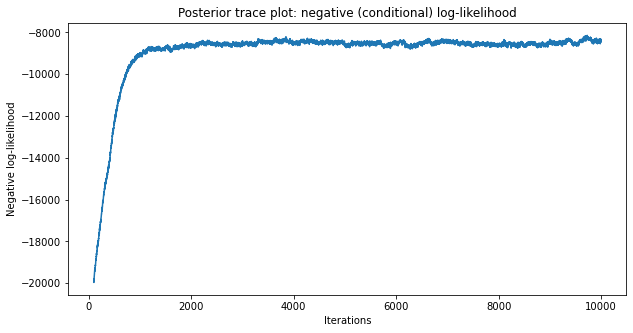

In [80]:
plt.figure(figsize = (10, 5))

plt.plot(np.arange(len(APost))[100:], loglik[100:])
plt.xlabel("Iterations")
plt.ylabel("Negative log-likelihood")
plt.title("Posterior trace plot: negative (conditional) log-likelihood")
# plt.savefig(directory + "trace_neg_like")
plt.show()

In [81]:
# Switch Label
deltaAT = []

s_trueA = trueA.copy()
s_trueA = np.where(s_trueA < 0, -10, s_trueA)
for j in range(len(labelS)):
    s_trueA = np.where(s_trueA == j, -1*labelS[j], s_trueA)
s_trueA = abs(s_trueA)    
s_trueA = np.where(s_trueA == 10, -1, s_trueA)

In [82]:
for i in range(len(APost)):
    deltaAT.append(np.sum(APost[i][trueW==1] != s_trueA[trueW==1]))

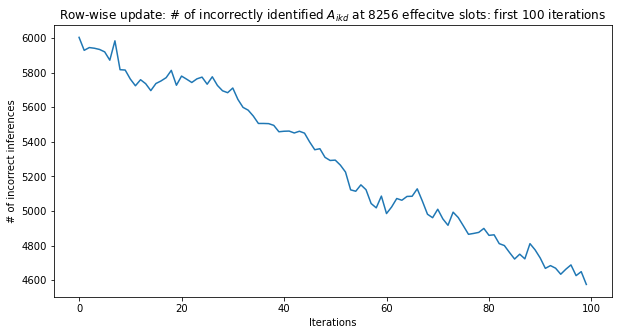

In [83]:
plt.figure(figsize=(10,5))
plt.plot(deltaAT[:100])
plt.xlabel("Iterations")
plt.ylabel(r"# of incorrect inferences")
plt.title("Row-wise update: # of incorrectly identified $A_{ikd}$ at %d effecitve slots: first 100 iterations" % np.sum(trueW==1))

# plt.savefig(directory + 'correct_effectiveA_%d'%100)
plt.show()

In [84]:
np.sum(trueW == 1)

8256

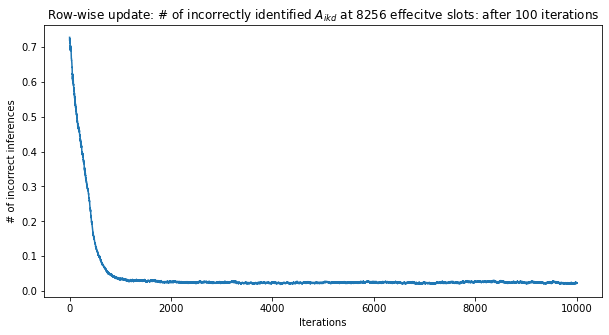

In [85]:
plt.figure(figsize=(10,5))
plt.plot(deltaAT/np.sum(trueW == 1))
plt.xlabel("Iterations")
plt.ylabel(r"# of incorrect inferences")
plt.title("Row-wise update: # of incorrectly identified $A_{ikd}$ at %d effecitve slots: after 100 iterations" % np.sum(trueW==1))

# plt.savefig(directory + 'correct_effectiveA_%d'%2900)
plt.show()

Assessing convergence

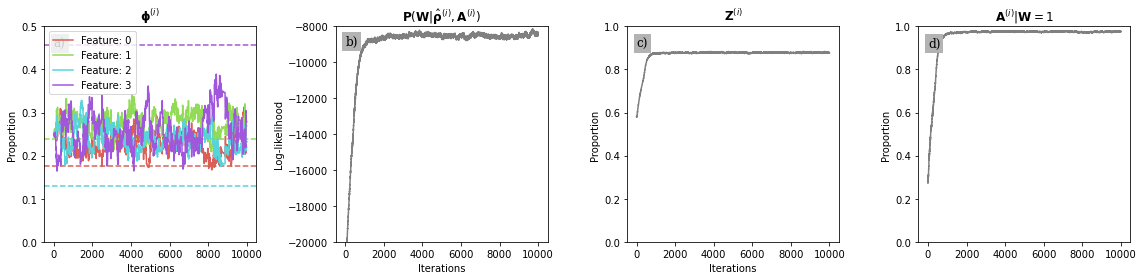

In [235]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 4))

for k in range(K):
    axs[0].plot(phiProp[:, labelS[k]], color=colors[k], label='Feature: %d' % k)
    axs[0].axhline(truePhi[k]/truePhi.sum(), color=colors[k], linestyle = "--")
    axs[0].set_ylim([0, 0.5])
    axs[0].set_ylabel("Proportion")
    axs[0].legend()
    axs[0].set_title(r"$\mathbf{\phi}^{(i)}$")
    
axs[1].plot(np.arange(len(APost)), loglik, color = 'grey')
axs[1].set_ylabel("Log-likelihood")
axs[1].set_xlabel("Iterations")
axs[1].set_title(r"$\mathbf{P}(\mathbf{W} | \hat{\mathbf{\rho}}^{(i)}, \mathbf{A}^{(i)})$")
axs[1].set_ylim([-20000, -8000])

axs[2].plot([np.sum([ZPost[i][:, labelS, :] == trueZ])/trueZ.size for i in range(len(ZPost))], color = 'grey')
axs[2].set_ylim([0, 1])
axs[2].set_title(r"$\mathbf{Z}^{(i)}$")
axs[2].set_ylabel("Proportion")

axs[3].plot(np.arange(len(APost)), 1 - deltaAT/np.sum(trueW == 1), color = 'grey')
axs[3].set_title(r"$\mathbf{A}^{(i)} | \mathbf{W} = 1$")
axs[3].set_ylim([0, 1])
axs[3].set_ylabel("Proportion")

for i in range(3):
    axs[i].set_xlabel("Iterations")

axs[0].text(0.00, 0.5 * 0.95, "a)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs[1].text(0, -8500, "b)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs[2].text(0.00, 0.95, "c)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs[3].text(0.00, 0.95, "d)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

plt.tight_layout()
plt.savefig("../../Figures/UM03_CONV", dpi = 400)
    

The issue of inactive, ineffective features

**Analysis of Z: Paper, ineffective and effective clusters**

In [182]:
def count_feature_types(A, Z, Nt, W, return_total = False):
    """
        Returns the number of patients with inactive features, i.e., features that are present within an individual,
        but not being assigned any of morbidity slot of hers.
    """
    maxNt, D, T = A.shape
    count_inactive = count_ineffective = 0

    
    for t in range(T):
        for i in range(Nt[t]):
            if np.sum(W[i,:,t]) > 0:
                idx_inactive = np.setdiff1d(np.argwhere(Z[i,:,t] > 0), np.unique(A[i,:,t]))
                idx_ineffective = np.setdiff1d(np.unique(A[i,:,t]), np.unique(A[i,:,t][np.argwhere(W[i,:,t] > 0)]))
            
            count_inactive += len(idx_inactive)
            count_ineffective += len(idx_ineffective)
                
    if return_total:
        return count_inactive, count_ineffective, np.sum(Z[Z > 0])
    
    return count_inactive, count_ineffective

In [204]:
true_inactive, true_ineffect, true_total = count_feature_types(trueA, trueZ, Nt, trueW,  return_total = True)

In [184]:
num_inactive_sam = np.zeros(len(APost))
num_ineffect_sam = np.zeros(len(APost))
for i in tq.tqdm(range(len(APost))):
    num_ina, num_ine = count_feature_types(APost[i], ZPost[i+1], Nt, trueW)
    num_inactive_sam[i] = num_ina
    num_ineffect_sam[i] = num_ine

100%|███████████████████████████████████████| 10000/10000 [58:07<00:00,  2.87it/s]


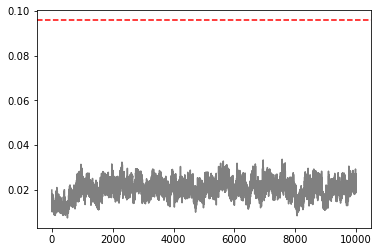

In [201]:
plt.plot(num_inactive_sam / true_total, color = 'grey')
plt.axhline(true_inactive / true_total, color = 'red', linestyle = "--")

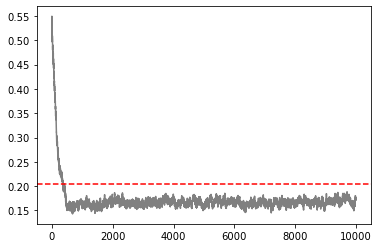

In [206]:
plt.plot(num_ineffect_sam / true_total, color = 'grey')
plt.axhline(true_ineffect / true_total, color = 'red', linestyle = "--")

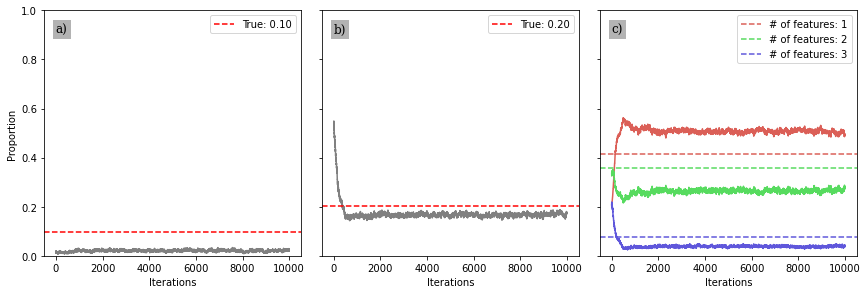

In [226]:
# code to plot posterior distribution over # of features
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharey='all')

axs[0].plot(num_inactive_sam / true_total, color = 'grey')
axs[0].axhline(true_inactive / true_total, color = 'red', linestyle = "--", 
               label = "True: {:.2f}".format(true_inactive / true_total))
axs[0].legend()

axs[1].plot(num_ineffect_sam / true_total, color = 'grey')
axs[1].axhline(true_ineffect / true_total, color = 'red', linestyle = "--", 
               label = "True: {:.2f}".format(true_ineffect / true_total))
axs[1].legend()

subcolors = sns.color_palette('hls', 3)

for j, k in enumerate(range(1, K)):
    axs[2].plot(cls_per_it[:, k, :].sum(axis=1) / sum(Nt), color=subcolors[j])
    axs[2].axhline(get_num_of_cls_per_it([trueZ], Nt)[:, k, :].sum(axis=1) / sum(Nt), 
                   color = subcolors[j], linestyle = "--", label="# of features: %d" % k)
    axs[2].legend()
    axs[2].set_ylim([0, 1])

plt.tight_layout()

axs[0].text(0.00, 0.95, "a)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

axs[1].text(0.00, 0.95, "b)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs[2].text(0.00, 0.95, "c)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

axs[0].set_ylabel("Proportion")

for i in range(3):
    axs[i].set_xlabel("Iterations")

plt.savefig("../../Figures/UM03_FEATURE", dpi = 400)



Assessing posterior distribution

In [230]:
time = [0, 3, 5, 9]
colors = sns.color_palette('hls', K)
label_name = ['D:0,1,3,5', 'D:5,6,8', 'D:10,11,12,15','D:15,16,17,18']

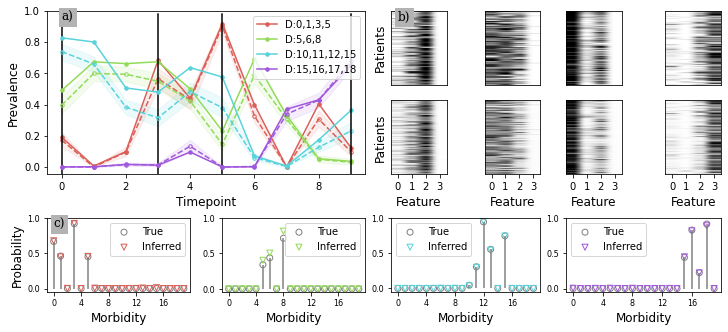

In [233]:
fig, axs = plt.subplot_mosaic([['b)', 'b)', 'b)', 'b)', 'a1)', 'a2)', 'a3)', 'a4)'], ['b)', 'b)', 'b)', 'b)', 'a11)', 'a12)', 'a13)', 'a14)'], ['c)', 'c)', 'd)', 'd)', 'e)', 'e)', 'f)', 'f)']],
                               figsize=(10,4.5), constrained_layout=True)
# plt.delaxes(axs['e)'])
j = 0
for k in range(K):
    axs['b)'].plot(trueX.T[:,k], color=colors[k], label=label_name[k], marker='o', markersize=3.5, fillstyle='full')
    axs['b)'].plot(np.mean(np.array(XPost[burnin:]), axis=0).T[:,labelS[k]], linestyle='dashed', color=colors[k], marker='o', markersize=3.5, fillstyle='none')
    axs['b)'].fill_between(np.arange(T), down[labelS[k],:], up[labelS[k],:], alpha=.1, color=colors[k]) 
    axs['b)'].legend()
    axs['b)'].set_yticks(np.linspace(0,1,6))
    axs['b)'].set_xlabel("Timepoint",fontsize='large')
    axs['b)'].set_ylabel("Prevalence",fontsize='large')
    axs['b)'].axvline(time[j], ymin=0, ymax=0.98, color='black')
    j += 1
for k, right in enumerate(['c)', 'd)', 'e)', 'f)']):
    axs[right].scatter(np.arange(D), trueRho[k,:], marker='o', color='grey', facecolor='none', label="True")
    axs[right].stem(np.arange(D), trueRho[k,:], linefmt='grey', basefmt= ' ', markerfmt=' ')
    
    axs[right].set_xticks(np.linspace(0,D,6))
    axs[right].set_xlabel("Morbidity", fontsize='large') 
    axs[right].scatter(np.arange(D), postRho[:,labelS[k]], marker='v', color=colors[k], facecolor='none', label="Inferred")
    axs[right].legend(loc='upper right')
    if right == 'c)':
        axs[right].set_ylabel("Probability", fontsize='large')
    if right == 'e)':
        axs[right].legend(loc=9)
    if right in ['e)', 'f)']:
        axs[right].legend(loc='upper left')
    axs[right].set_yticks(np.linspace(0,1,3))
    for label in (axs[right].get_xticklabels() + axs[right].get_yticklabels()):
        label.set_fontsize(8)

for i, right in enumerate(['a1)', 'a2)', 'a3)', 'a4)']):
    axs[right].imshow(trueZ[:,:,time[i]], cmap='Greys', aspect='auto')
    axs[right].xaxis.set_major_locator(plt.NullLocator())
    axs[right].yaxis.set_major_locator(plt.NullLocator())

    if right == 'a1)':
        axs[right].set_ylabel('Patients', fontsize='large')
for i, right in enumerate(['a11)', 'a12)', 'a13)', 'a14)']):
    axs[right].imshow(np.mean(ZPost,axis=0)[:,labelS,time[i]], cmap='Greys', aspect='auto')
    axs[right].yaxis.set_major_locator(plt.NullLocator())
    axs[right].set_xticks(np.arange(K))
    axs[right].set_xlabel("Feature", fontsize='large')
    if right == 'a11)':
        axs[right].set_ylabel('Patients', fontsize='large')
axs['b)'].text(0.00, 1.00, "a)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

axs['a1)'].text(0.00, 1.00, "b)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs['c)'].text(0.00, 1.00, "c)", 
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

plt.savefig("../../Figures/UM03_POST", dpi = 400)

# for label, ax in axs.items():
#     if label = 'a)':
#         ax.label_outer()
# plt.savefig(directory + 'ex3C_outcome_v03')

In [ ]:
with open('WFIBP_result.dat', "wb") as f:
    pickle.dump(dist_rho, f)
    pickle.dump([x, down, up], f)